In [1]:
# Common Imports

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
import os
from PIL import Image

In [2]:
# Helper Functions 

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=150):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

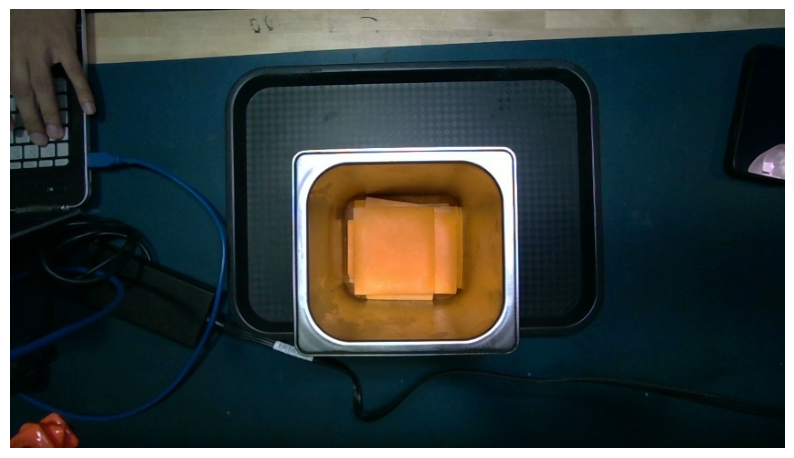

In [3]:
# Diplay image

image = Image.open('/home/user/data/sam_experiments/image_0000.jpg')
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
# Pedict using SAM

import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/home/user/sam2/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cpu")

predictor = SAM2ImagePredictor(sam2_model)

In [5]:
predictor.set_image(image)

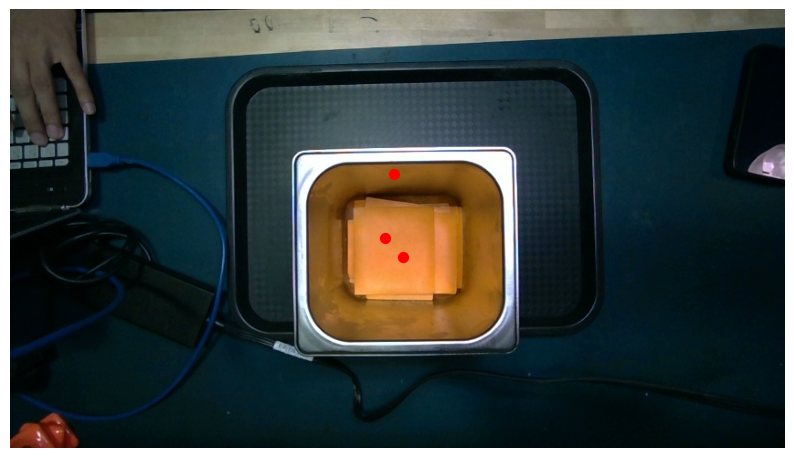

In [6]:
input_points = np.array([[430, 270],[410, 250], [420, 180]])
input_labels = np.array([1, 1, 0])

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.scatter(input_points[:, 0], input_points[:, 1], color="red", s=50, label="Points")
plt.axis('off')
plt.show()  

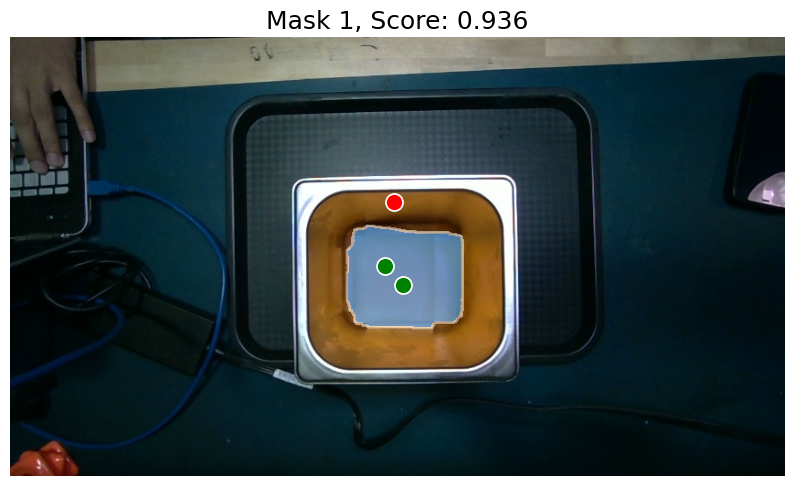

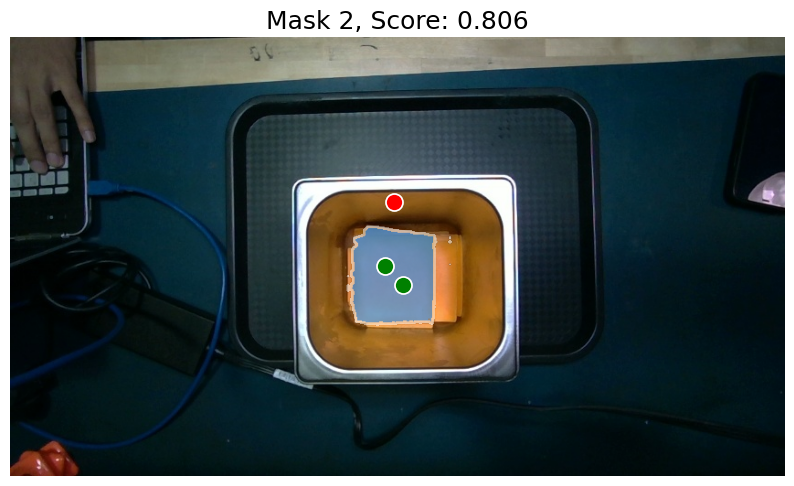

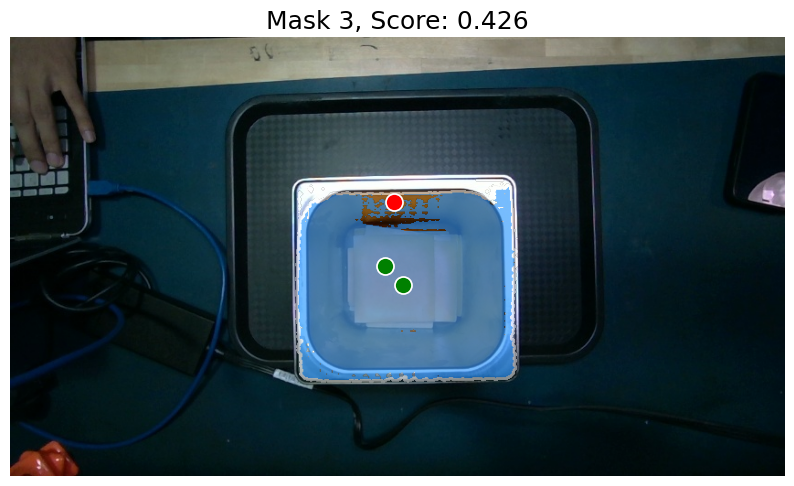

In [7]:
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

show_masks(image, masks, scores, point_coords=input_points, input_labels=input_labels, borders=True)

In [16]:
idx_filtered = np.where(scores>0.70)
masks_filtered = masks[idx_filtered]

min_area = np.inf
target_idx = -1
for idx, mask in zip(list(idx_filtered[0]), masks_filtered):
    print(f"{idx}: {np.sum(mask)}")
    if np.sum(mask) < min_area:
        min_area = np.sum(mask)
        target_idx = idx

0: 13118.0
1: 9100.0


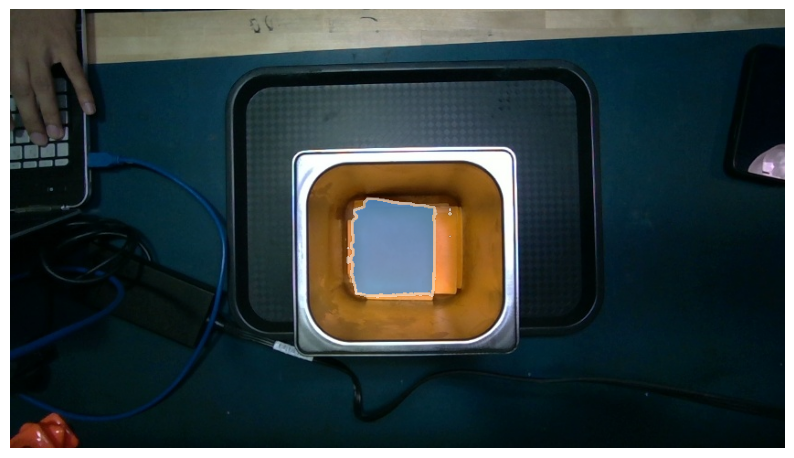

In [20]:
show_masks(image, masks[target_idx:target_idx+1], scores = scores[target_idx: target_idx + 1])

In [10]:
scores

array([0.936018  , 0.80553097, 0.42629328], dtype=float32)